<a href="https://colab.research.google.com/github/EJH22/MSc-TranslationalNeuroscience-Module3/blob/main/cifar_10_non_corrupted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Notebook starter code:

In [1]:
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as torchdata
import numpy as np
import torch.utils.data as torchdata
import numpy as np
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import typing
from tqdm import tqdm

# Data transformation
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the CIFAR-10 dataset
cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:10<00:00, 16031011.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
#### Can improve training times significantly by keeping data in RAM
#### If not enough RAM, remove this cell

class ToMemory(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.memory_dataset = {}

    def __getitem__(self, index):
        if index in self.memory_dataset:
            return self.memory_dataset[index]
        output = self.dataset[index]
        self.memory_dataset[index] = output
        return output

    def __len__(self):
        return len(self.dataset)

cifar10_train = ToMemory(cifar10_train)
cifar10_test = ToMemory(cifar10_test)

### Adding Source and splitting datasets:

In [3]:
class DatasetWithSource(torchdata.Dataset):
    def __init__(self, dataset, source_list, unreliable_sources, corruption_prob, seed=0):
        self.dataset = dataset
        self.source_list = source_list
        self.unreliable_sources = unreliable_sources
        self.corruption_prob = corruption_prob
        self.sources = np.random.default_rng(seed).choice(source_list, len(dataset), replace=True) ########### changed to random sources

    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        source = self.source_list[idx % len(self.source_list)]
        if source in self.unreliable_sources and np.random.rand() < self.corruption_prob:
            img = torch.randn_like(img) * 0.5 + 0.5
        return img, target, source

    def __len__(self):
        return len(self.dataset)

In [4]:
# Splitting the data
split_ratio = 0.8  # Specifies the split ratio for train and validation set
dataset_size = len(cifar10_train)
train_size = int(split_ratio * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = torch.utils.data.random_split(cifar10_train, [train_size, val_size])
train_dataset_corr, val_dataset_corr = torch.utils.data.random_split(cifar10_train, [train_size, val_size])

In [5]:
train_dataset = DatasetWithSource(train_dataset, np.arange(10), [0, 1, 2, 3, 4], 0)
val_dataset = DatasetWithSource(val_dataset, np.arange(10), [0, 1, 2, 3, 4], 0)
test_dataset = DatasetWithSource(cifar10_test, np.arange(10), [0, 1, 2, 3, 4], 0)

In [6]:
import torch
from torch.utils.data import Dataset, random_split

def split_dataset(dataset, n_splits=5):
    # Compute the length of each split
    length = len(dataset)
    lengths = [length // n_splits for _ in range(n_splits)]
    if sum(lengths) < length:
        lengths[-1] += length - sum(lengths)
    # Use the random_split function
    return random_split(dataset, lengths)

In [7]:
train_splits = split_dataset(train_dataset, n_splits=5)
val_splits = split_dataset(val_dataset, n_splits=5)
test_splits = split_dataset(test_dataset, n_splits=5)

In [8]:
train_dataset_subsets = train_splits
validation_dataset_subsets = val_splits
test_dataset_subsets = test_splits

### Defining classes:

In [9]:
##### below is equivalent. choose one or the other, whatever makes most sense to you

def class_data_subsets(dataset, subset_classes):
    dataset_subsets = []
    # iterates over the subsets of classes
    for subset in tqdm(subset_classes, total=len(subset_classes), desc="Creating subsets"):
        subset_idx = []
        # finds idx of targets in that subset of classes
        for idx, data in enumerate(dataset):
            if data[1] in subset:
                subset_idx.append(idx)
        dataset_subsets.append(
            torchdata.Subset(
                dataset,
                subset_idx
            )
        )
    return dataset_subsets

In [10]:
#subset_classes = [[8,0], [2,4], [3,5], [1,8], [7,9]]# or if picking randomly
seed = 42
subset_classes = np.random.default_rng(seed).permutation(10).reshape(5, 2).tolist()

train_dataset_subsets_class = class_data_subsets(train_dataset, subset_classes) ### using functions above to split data
validation_dataset_subsets_class = class_data_subsets(val_dataset, subset_classes)
test_dataset_subsets_class = class_data_subsets(test_dataset, subset_classes)

Creating subsets: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


In [11]:
##Checking the data is split correctly

for data_subset in train_dataset_subsets_class:
    targets = set() # set only holds unique values
    sources = set()
    for img, target, source in data_subset:
        targets.add(target)
        sources.add(source)
    print(f"Training data: unique targets: {targets}, unique sources: {sources}")

for data_subset in validation_dataset_subsets_class:
    targets = set() # set only holds unique values
    sources = set()
    for img, target, source in data_subset:
        targets.add(target)
        sources.add(source)
    print(f"Validation data: unique targets: {targets}, unique sources: {sources}")

for data_subset in test_dataset_subsets_class:
    targets = set() # set only holds unique values
    sources = set()
    for img, target, source in data_subset:
        targets.add(target)
        sources.add(source)
    print(f"Test data: unique targets: {targets}, unique sources: {sources}")

Training data: unique targets: {5, 6}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Training data: unique targets: {0, 7}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Training data: unique targets: {2, 3}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Training data: unique targets: {9, 4}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Training data: unique targets: {8, 1}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Validation data: unique targets: {5, 6}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Validation data: unique targets: {0, 7}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Validation data: unique targets: {2, 3}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Validation data: unique targets: {9, 4}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Validation data: unique targets: {8, 1}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Test data: unique targets: {5, 6}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Test data: unique targets: {0, 7}, unique source

In [12]:
## subset_classes = [[5,6], [0,7], [2,3], [9,4], [8,1]]

### Visualising Datasets:

Split 1:


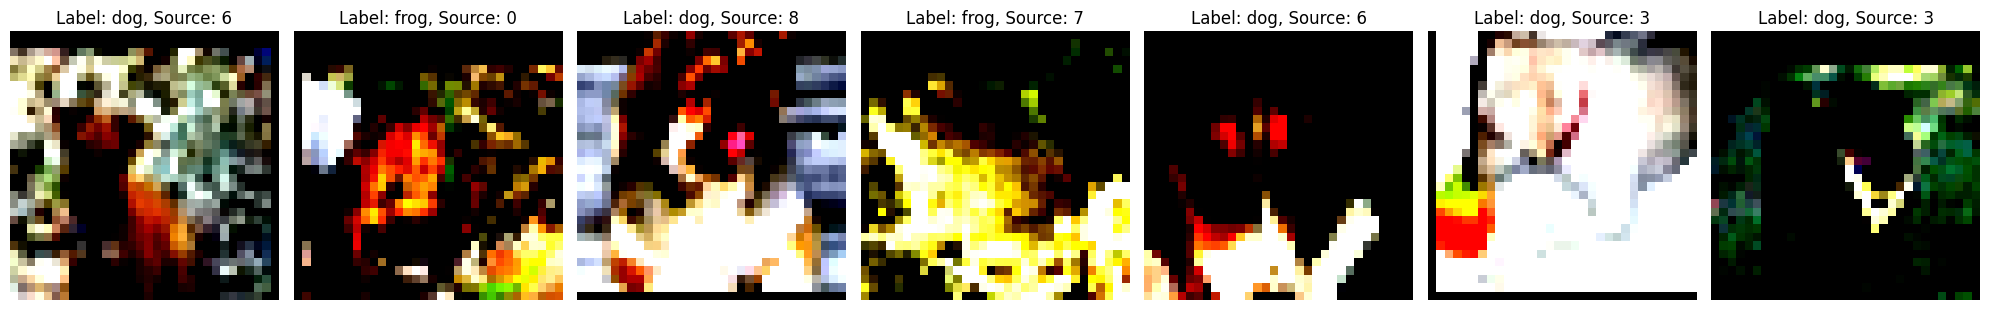

Split 2:


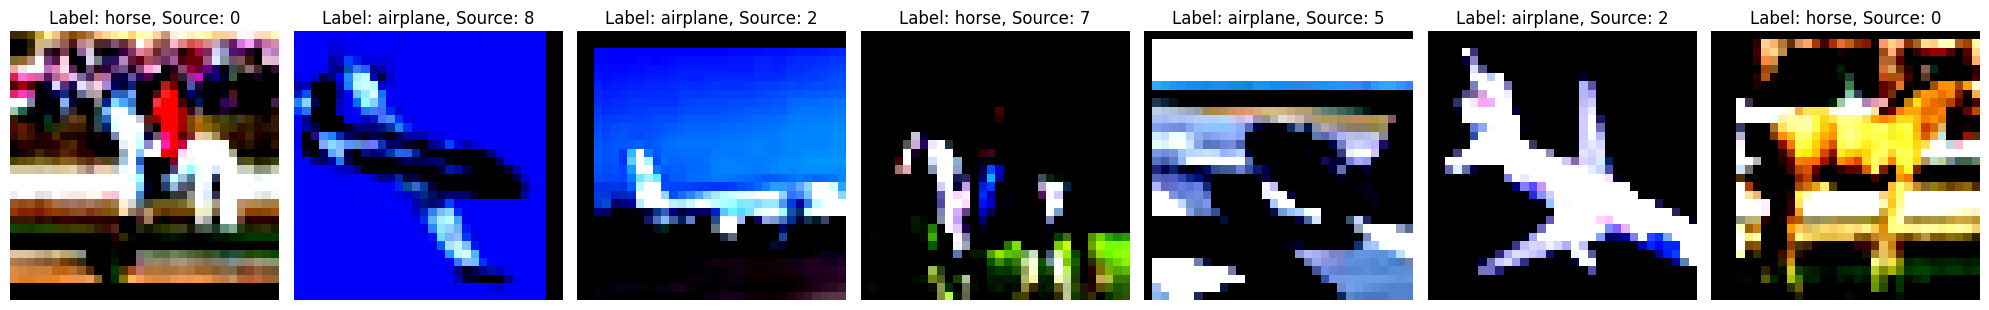

Split 3:


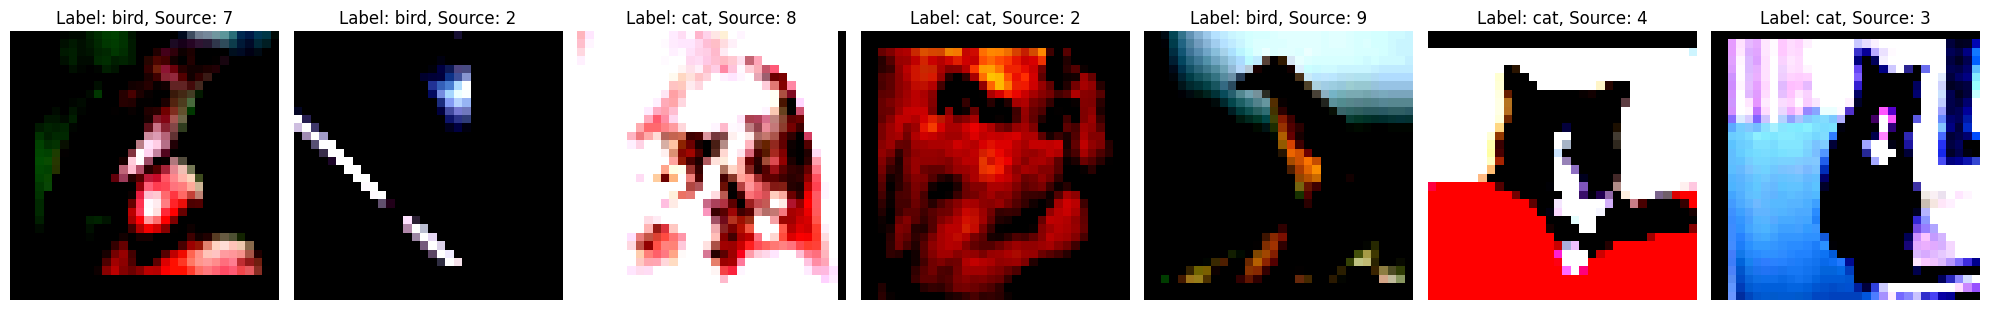

Split 4:


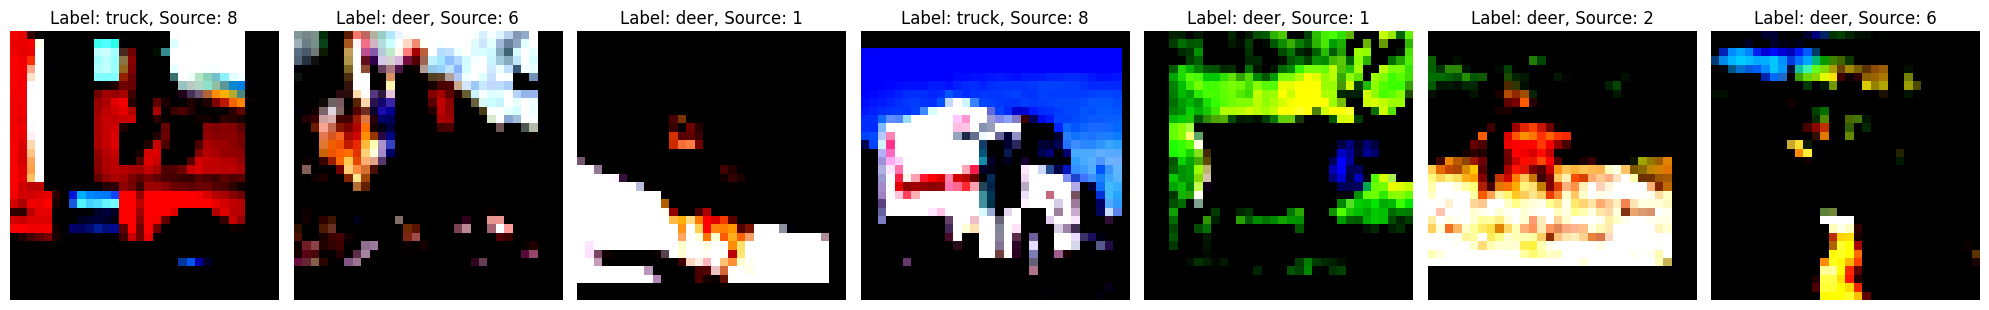

Split 5:


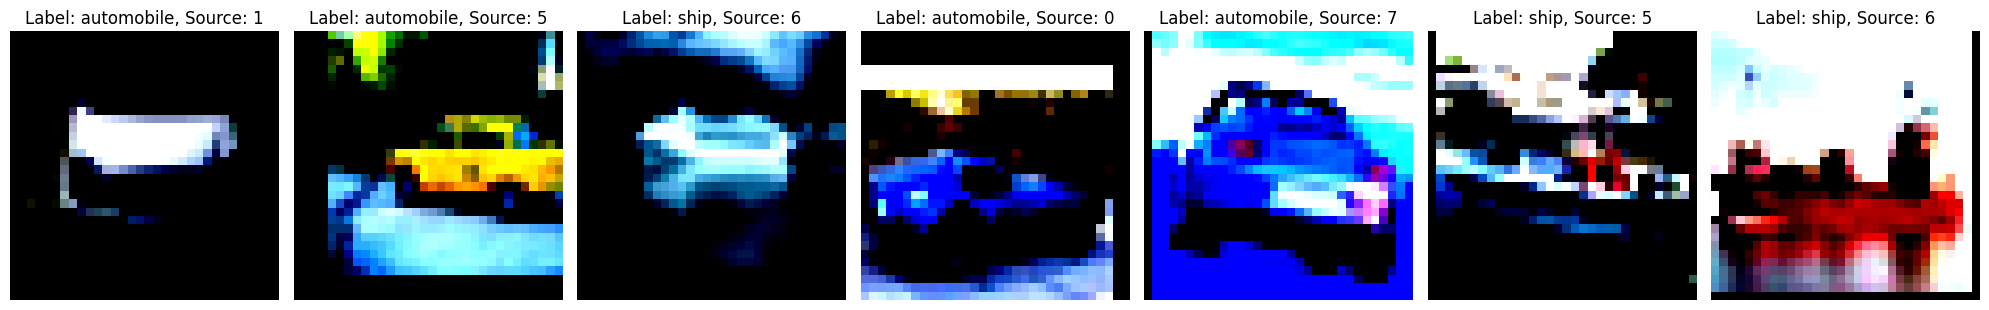

In [13]:
import matplotlib.pyplot as plt
import numpy as np

dataloaders = [torchdata.DataLoader(dataset, batch_size=10, shuffle=True) for dataset in train_dataset_subsets_class]

# CIFAR-10 class names
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Iterate over the splits
for split_idx, loader in enumerate(dataloaders):
    print(f"Split {split_idx + 1}:")

    # Calculate the number of rows and columns for subplots
    num_images = 7
    num_rows = 1
    num_cols = num_images

    # Create subplots with a row layout
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4))

    # Get the first batch from the DataLoader
    images, targets, sources = next(iter(loader))

    # Iterate over the images and targets
    for i in range(num_images):
        image = images[i]
        target = targets[i]
        source = sources[i]

        # Convert tensor to numpy array
        image = image.numpy()

        # Clip pixel values to the valid range [0, 1]
        image = np.clip(image, 0, 1)

        # Transpose image dimensions to match CIFAR format: (C, H, W)
        image = np.transpose(image, (1, 2, 0))

        # Display the image in the corresponding subplot
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {class_names[target]}, Source: {source.item()}")
        axes[i].axis('off')

    # Adjust the layout of subplots and display the plot
    plt.tight_layout()
    plt.show()

## Batch Sampler:

In [ ]:
class GroupBatchSampler(torch.utils.data.Sampler):
    def __init__(
        self,
        group: typing.Union[np.ndarray, typing.List[typing.Any]],
        seed: typing.Union[None, int] = None,
        batch_size: int = 20,
        upsample: typing.Union[bool, typing.Dict[typing.Any, int]] = False,
    ):
        """
        A pytorch batch sampler that returns a batch of samples with
        that same group. This means each batch will be drawn from
        only a single group.

        Examples
        ---------

        The following will batch the training dataset
        into batches that contains single group, given
        by the :code:`group` argument

        .. code-block::

            >>> dl = torch.utils.data.DataLoader(
            ...     train_dataset,
            ...     batch_sampler=GroupBatchSampler(
            ...         group=train_group,
            ...         seed=seed,
            ...         batch_size=64,
            ...         )
            ...     )


        Arguments
        ---------

        - group: typing.Union[np.ndarray, typing.List[typing.Any]]:
            The group of the data points. This should be
            the same length as the data set that is to be
            sampled.

        - seed: int (optional):
            Random seed for group order shuffling and
            shuffling of points in each batch.
            Defaults to :code:`None`.

        - batch_size: int, (optional):
            The size of each batch. Each batch
            will be smaller than or equal in
            size to this value.
            Defaults to :code:`20`.

        - upsample: typing.Union[bool, typing.Dict[typing.Any, int]], (optional):
            Whether to upsample the smaller groups,
            so that all groups have the same size.
            Defaults to :code:`False`.


        """

        rng = np.random.default_rng(seed)

        group = np.asarray(group)

        upsample_bool = upsample if type(upsample) == bool else True

        if upsample_bool:
            upsample_idx, group = imblearn.over_sampling.RandomOverSampler(
                sampling_strategy="all" if type(upsample) == bool else upsample,
                random_state=rng.integers(1e9),
            ).fit_resample(np.arange(len(group)).reshape(-1, 1), group)
            upsample_idx = upsample_idx.reshape(-1)

        group_unique, group_counts = np.unique(group, return_counts=True)
        group_batches = (
            np.repeat(
                np.ceil(np.max(group_counts) / batch_size).astype(int),
                len(group_unique),
            )
            if upsample
            else np.ceil(group_counts / batch_size).astype(int)
        )
        rng = np.random.default_rng(rng.integers(low=0, high=1e9, size=(4,)))
        n_batches = np.sum(group_batches)
        self.out = -1 * np.ones((n_batches, batch_size))
        group_order = rng.permutation(np.repeat(group_unique, group_batches))

        for g in group_unique:
            # get the index of the items from that group
            group_idx = np.argwhere(group == g).reshape(-1)
            # shuffle the group index
            rng.shuffle(group_idx)
            # get the section of the output that we will edit
            out_temp = self.out[group_order == g].reshape(-1)
            # replace the values with the index of the items
            out_temp[: len(group_idx)] = (
                upsample_idx[group_idx] if upsample else group_idx
            )
            out_temp = out_temp.reshape(-1, batch_size)
            rng.shuffle(out_temp, axis=0)
            self.out[group_order == g] = out_temp
            rng = np.random.default_rng(rng.integers(low=0, high=1e9, size=(3,)))

        self.out = [list(batch[batch != -1].astype(int)) for batch in self.out]

        return

    def __iter__(self):
        return iter(self.out)

    def __len__(self):
        return len(self.out)

### Corrupting Dataset:

In [25]:
train_dataset_corrupt = DatasetWithSource(train_dataset_corr, np.arange(10), [0, 1, 2, 3, 4], 0.5)
val_dataset_corrupt = DatasetWithSource(val_dataset_corr, np.arange(10), [0, 1, 2, 3, 4], 0.5)
test_dataset_corrupt = DatasetWithSource(cifar10_test, np.arange(10), [0,1,2,3,4], 0)

In [26]:
train_splits_corrupt = split_dataset(train_dataset_corrupt, n_splits=5)
val_splits_corrupt = split_dataset(val_dataset_corrupt, n_splits=5)
test_splits_corrupt = split_dataset(test_dataset_corrupt, n_splits=5)

In [27]:
train_dataset_subsets_corrupt = train_splits_corrupt
validation_dataset_subsets_corrupt = val_splits_corrupt
test_dataset_subsets_corrupt = test_splits_corrupt

In [28]:
def class_data_subsets_with_corruption(dataset, subset_classes):
    dataset_subsets = []
    # iterates over the subsets of classes
    for subset in tqdm(subset_classes, total=len(subset_classes), desc="Creating subsets"):
        subset_idx = []
        # finds idx of targets in that subset of classes
        for idx, data in enumerate(dataset):
            if data[1] in subset:
                subset_idx.append(idx)
        dataset_subsets.append(
            torchdata.Subset(
                dataset,
                subset_idx
            )
        )
    return dataset_subsets

In [30]:
#subset_classes = [[8,0], [2,4], [3,5], [1,6], [7,9]]# or if picking randomly
seed = 42
subset_classes = np.random.default_rng(seed).permutation(10).reshape(5, 2).tolist()

train_dataset_subsets_class_corr = class_data_subsets_with_corruption(train_dataset_corrupt, subset_classes)
validation_dataset_subsets_class_corr = class_data_subsets_with_corruption(val_dataset_corrupt, subset_classes)
test_dataset_subsets_class_corr = class_data_subsets_with_corruption(test_dataset_corrupt, subset_classes)

Creating subsets: 100%|██████████| 5/5 [00:00<00:00, 72.41it/s]


In [31]:
##Checking the data is split correctly

for data_subset in train_dataset_subsets_class_corr:
    targets = set() # set only holds unique values
    sources = set()
    for img, target, source in data_subset:
        targets.add(target)
        sources.add(source)
    print(f"Training data: unique targets: {targets}, unique sources: {sources}")

for data_subset in validation_dataset_subsets_class_corr:
    targets = set() # set only holds unique values
    sources = set()
    for img, target, source in data_subset:
        targets.add(target)
        sources.add(source)
    print(f"Validation data: unique targets: {targets}, unique sources: {sources}")

for data_subset in test_dataset_subsets_class_corr:
    targets = set() # set only holds unique values
    sources = set()
    for img, target, source in data_subset:
        targets.add(target)
        sources.add(source)
    print(f"Test data: unique targets: {targets}, unique sources: {sources}")

Training data: unique targets: {5, 6}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Training data: unique targets: {0, 7}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Training data: unique targets: {2, 3}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Training data: unique targets: {9, 4}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Training data: unique targets: {8, 1}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Validation data: unique targets: {5, 6}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Validation data: unique targets: {0, 7}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Validation data: unique targets: {2, 3}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Validation data: unique targets: {9, 4}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Validation data: unique targets: {8, 1}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Test data: unique targets: {5, 6}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Test data: unique targets: {0, 7}, unique source

### Visualising Corrupted Dataset



Split 1:


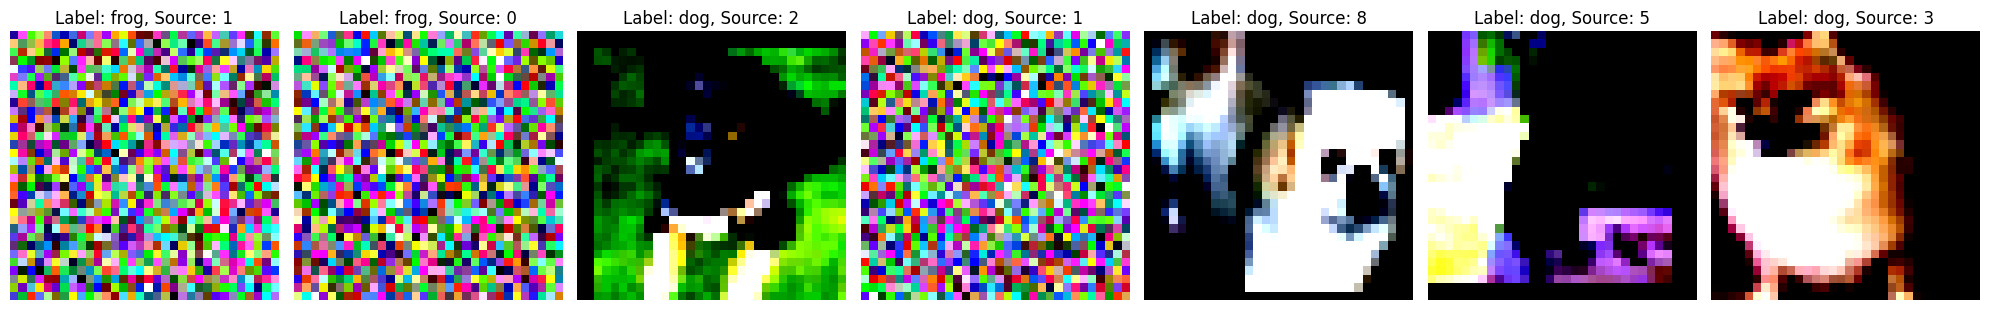

Split 2:


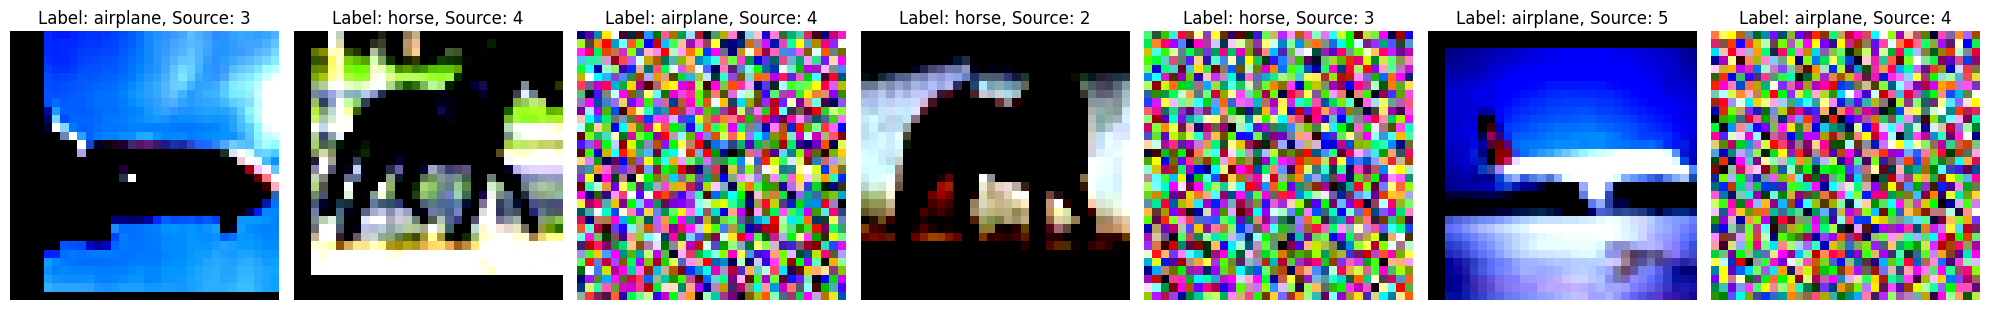

Split 3:


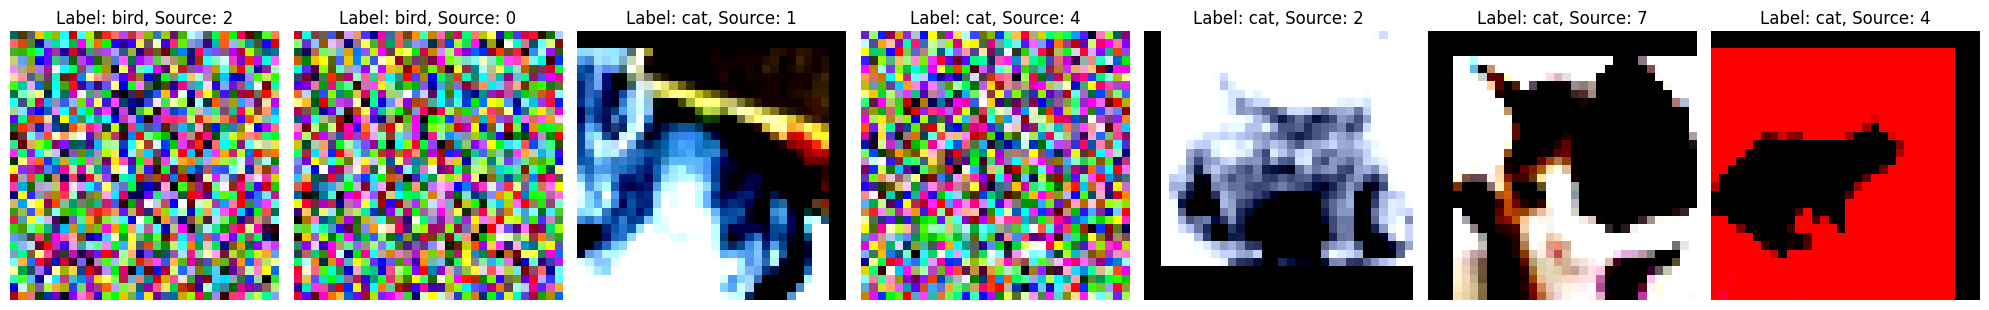

Split 4:


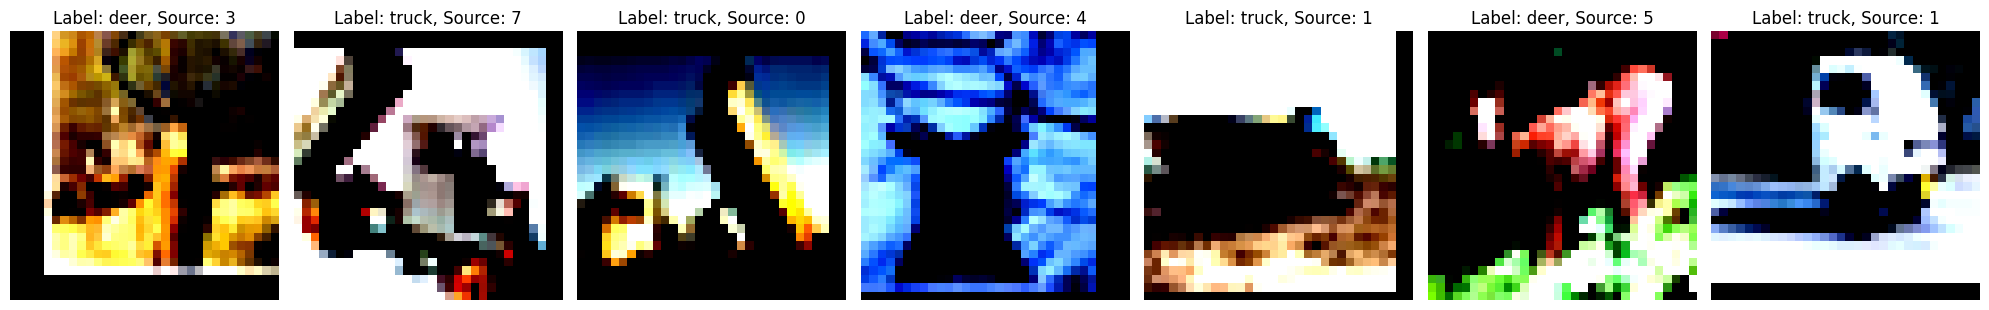

Split 5:


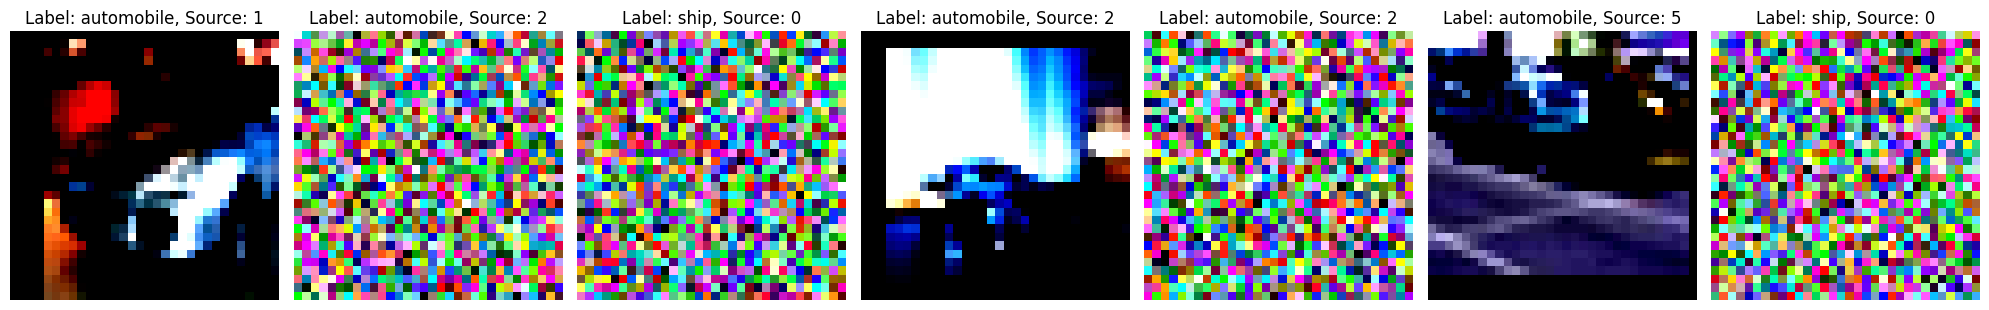

In [32]:
import matplotlib.pyplot as plt
import numpy as np

dataloaders = [torchdata.DataLoader(dataset, batch_size=10, shuffle=True) for dataset in train_dataset_subsets_class_corr]

# CIFAR-10 class names
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Iterate over the splits
for split_idx, loader in enumerate(dataloaders):
    print(f"Split {split_idx + 1}:")

    # Calculate the number of rows and columns for subplots
    num_images = 7
    num_rows = 1
    num_cols = num_images

    # Create subplots with a row layout
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4))

    # Get the first batch from the DataLoader
    images, targets, sources = next(iter(loader))

    # Iterate over the images and targets
    for i in range(num_images):
        image = images[i]
        target = targets[i]
        source = sources[i]

        # Convert tensor to numpy array
        image = image.numpy()

        # Clip pixel values to the valid range [0, 1]
        image = np.clip(image, 0, 1)

        # Transpose image dimensions to match CIFAR format: (C, H, W)
        image = np.transpose(image, (1, 2, 0))

        # Display the image in the corresponding subplot
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {class_names[target]}, Source: {source.item()}")
        axes[i].axis('off')

    # Adjust the layout of subplots and display the plot
    plt.tight_layout()
    plt.show()

### Dataloaders for corrupt and non-corrupt:



In [33]:
# Define the data loaders
train_dataloaders = [torchdata.DataLoader(train_ds, batch_size=64, shuffle=True) for train_ds in train_dataset_subsets_class]
val_dataloaders = [torchdata.DataLoader(val_ds, batch_size=64, shuffle=True) for val_ds in validation_dataset_subsets_class]
test_dataloaders = [torchdata.DataLoader(test_ds, batch_size=64, shuffle=True) for test_ds in test_dataset_subsets_class]


## Corrupt DataLoaders

train_dl_corr = [torchdata.DataLoader(cor_train, batch_size = 64, shuffle=True) for cor_train in train_dataset_subsets_class_corr]
val_dl_corr = [torchdata.DataLoader(cor_val, batch_size = 64, shuffle=True) for cor_val in validation_dataset_subsets_class_corr]
test_dl_corr = [torchdata.DataLoader(cor_test, batch_size = 64, shuffle=True) for cor_test in test_dataset_subsets_class_corr]

### Model that can be used:

#### Available Models:
- Simple Convolutional neural network defined as SimpleCNN
- Residual neural networks defined as resnet__ (either 18, 34, 50)
- Conv3Net

### Model Code:

In [34]:
### Simple CNN:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
            nn.Conv2d(64, 64, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(1),
            nn.Dropout(p=0.25),
        )
        self.flatten = nn.Flatten()  # Add a flattening layer
        self.classifier = nn.Sequential(nn.Linear(64, num_classes))

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)  # Flatten the output of the convolutional layers
        x = self.classifier(x)
        return x

# Initialize the network, loss, and optimizer
neural_net = SimpleCNN()

network = nn.Sequential(neural_net)


#model.fc = nn.Linear(512, 10)  # Adjust the output layer for CIFAR-10

In [35]:
import torch
import torch.nn as nn
import os

__all__ = [
    "ResNet",
    "resnet18",
    "resnet34",
    "resnet50",
]


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block,
        layers,
        num_classes=10,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                "or a 3-element tuple, got {}".format(replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group

        # CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
        self.conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False
        )
        # END

        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(
            block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0]
        )
        self.layer3 = self._make_layer(
            block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1]
        )
        self.layer4 = self._make_layer(
            block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2]
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer,
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x


def _resnet(arch, block, layers, pretrained, progress, device, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        script_dir = os.path.dirname(__file__)
        state_dict = torch.load(
            script_dir + "/state_dicts/" + arch + ".pt", map_location=device
        )
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet18", BasicBlock, [2, 2, 2, 2], pretrained, progress, device, **kwargs
    )


def resnet34(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet34", BasicBlock, [3, 4, 6, 3], pretrained, progress, device, **kwargs
    )


def resnet50(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet50", Bottleneck, [3, 4, 6, 3], pretrained, progress, device, **kwargs
    )

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import typing

class BaseModel(nn.Module):
    '''
    Base model, for meta or non meta learning.
    This class contains functions that can help in building
    and training models.

    '''
    def __init__(self,
                    **kwargs,
                    ):
        super(BaseModel, self).__init__()

        self.meta_training = False
        self.validating = False
        self.testing = False
        self.in_epoch = False
        self.in_batch = False
        self.traditional_training = False



    def _resolution_calc(self, dim_in:int, kernel_size:int=3,
                            stride:int=1, padding:int=0, dilation:int=1):
        '''
        Allows the calculation of resolutions after a convolutional layer.



        Arguments
        ---------

        - dim_in: int:
            The dimension of an image before convolution is applied.
            If dim_in is a :code:`list` or :code:`tuple`, then two dimensions
            will be returned.

        - kernel_size: int`, optional:
            Defaults to :code:`3`.

        - stride: int`, optional:
            Defaults to :code:`1`.

        - padding: int`, optional:
            Defaults to :code:`0`.

        - dilation: int`, optional:
            Defaults to :code:`1`.


        Returns
        --------

        - dim_out: int:
            The dimension size after the convolutional layer.


        '''
        if padding == 'valid':
            padding=0

        if type(dim_in) == list or type(dim_in) == tuple:
            out_h = dim_in[0]
            out_w = dim_in[1]
            out_h = (out_h + 2*padding - dilation * (kernel_size-1) - 1)/stride + 1
            out_w = (out_w + 2*padding - dilation * (kernel_size-1) - 1)/stride + 1

            return (out_h, out_w)

        return int(np.floor((dim_in + 2*padding -  (kernel_size - 1) - 1)/stride + 1))

    def _get_conv_params(self, layer):
        '''
        Given a pytorch Conv2d layer, this function can
        return a dictionary of the kernel size, stride
        and padding.



        Arguments
        ---------

        - layer: torch.nn.Conv2d:
            Pytorch convolutional layer.


        Returns
        --------

        - params: dict:
            Dictionary containing the parameters of
            the convolutional layer.


        '''
        kernel_size = layer.kernel_size[0] if type(layer.kernel_size) == tuple else layer.kernel_size
        stride = layer.stride[0] if type(layer.stride) == tuple else layer.stride
        padding = layer.padding[0] if type(layer.padding) == tuple else layer.padding
        return {'kernel_size': kernel_size, 'stride': stride, 'padding': padding}



    # the following allow for specific options during training.

    def epoch_start(self, obj=None, **kwargs):
        self.in_epoch = True
        return

    def batch_start(self, obj=None, **kwargs):
        self.in_batch = True
        return

    def batch_end(self, obj=None, **kwargs):
        self.in_batch = False
        return

    def val_start(self, obj=None, **kwargs):
        self.validating = True
        return

    def val_end(self, obj=None, **kwargs):
        self.validating = False
        return

    def epoch_end(self, obj=None, **kwargs):
        self.in_epoch = False
        return

    def test_start(self, obj=None, **kwargs):
        self.testing = True
        return

    def traditional_train_start(self, obj=None, **kwargs):
        self.traditional_training = True
        return

    def traditional_train_end(self, obj=None, **kwargs):
        self.traditional_training = False
        return

    def test_end(self, obj=None, **kwargs):
        self.testing = False
        return







class Conv3Net(BaseModel):
    def __init__(self,
                    input_dim=32,
                    in_channels=3,
                    channels=32,
                    n_out=10,
                    **kwargs,
                ):
        '''
        A Convolution model class.



        Arguments
        ---------

        - input_dim: int`, optional:
            The size of the input in one direction. This
            assumes that the input is a square image.
            Defaults to :code:`32`.

        - in_channels: int`, optional:
            The number of channels in the input.
            Defaults to :code:`3`.

        - channels: int`, optional:
            The number of channels in the first conv layer.
            The second and third conv layers will have
            double the number of channels.
            Defaults to :code:`32`.

        - n_out: int`, optional:
            The size of the output. :code:`2` should be
            used for binary classification.
            Defaults to :code:`10`.

        '''

        super(Conv3Net, self).__init__()

        self.input_dim = input_dim
        self.channels = channels
        self.n_out = n_out

        # =============== Cov Network ===============
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels, self.channels, 3, padding='valid')),
            ('relu1', nn.ReLU()),
            ('mp1', nn.MaxPool2d(2, 2)),
            ('conv2', nn.Conv2d(self.channels, self.channels*2, 3, padding='valid')),
            ('relu2', nn.ReLU()),
            ('mp2', nn.MaxPool2d(2, 2)),
            ('conv3', nn.Conv2d(self.channels*2, self.channels*2, 3, padding='valid')),
            ('relu3', nn.ReLU()),
            ('flatten', nn.Flatten()),
            ]))

        # =============== Linear ===============
        self.pm_fc = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(self.size_of_dim_out(self.input_dim)**2*(self.channels*2), 64)),
            ('relu1', nn.ReLU()),
            ]))

        # =============== Classifier ===============
        self.pm_clf = nn.Linear(64, n_out)
        #self.softmax = nn.LogSoftmax(dim=1)
        #self.softmax = nn.Softmax(dim=1)

        return

    def size_of_dim_out(self, dim_in):

        out = self._resolution_calc(dim_in=dim_in, **self._get_conv_params(self.net.conv1))
        out = self._resolution_calc(dim_in=out, **self._get_conv_params(self.net.mp1))
        out = self._resolution_calc(dim_in=out, **self._get_conv_params(self.net.conv2))
        out = self._resolution_calc(dim_in=out, **self._get_conv_params(self.net.mp2))
        out = self._resolution_calc(dim_in=out, **self._get_conv_params(self.net.conv3))

        return out


    def forward(self, X):
        out = self.pm_clf(
                self.pm_fc(
                    self.net(X)))
        return out

### LAP wrapper:

- changing some of the LAP so that it resets every time a new task begins:


In [37]:
import math
import numpy as np
import logging
import typing
import torch
from torch.utils.tensorboard import SummaryWriter


def weighted_avg_and_std(values, weights) -> typing.Tuple[np.array, np.array]:
    '''
    Return the weighted average and standard deviation.

    Arguments
    ---------

    - values: np.array:
        The array containing the values to
        calculate the mean and std on.

    - weights: np.array:
        The weights used in the mean and std.


    Returns
    ---------

    - out: typing.Tuple[np.array, np.array]:
        The weighted mean and std.

    '''
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))









class DiscreteRankingSTD(object):
    def __init__(self,
                    function=lambda x: x,
                    discrete_amount:float=0.005,
                    hold_off:int=0,
                    strictness:float=1.0,
                    ):
        '''
        This class calculates the level of depression
        to apply to gradient updates from a batch of
        source data.



        Arguments
        ---------

        - function: _type_, optional:
            This argument allows you to apply a function
            to the value before it is returned.
            Defaults to :code:`lambda x: x`.

        - discrete_amount: float, optional:
            The step size used when calculating the depression.
            Defaults to :code:`0.005`.

        - hold_off: int, optional:
            The number of calls to this function before
            depression will start. Until depression starts,
            this function will return 0 on each call.
            Defaults to :code:`0`.

        - strictness: float, optional:
            The number of standard deviations away from the
            mean loss a mean source loss has to be
            before depression is applied.
            Defaults to :code:`1.0`.


        '''
        self.function = function
        self.discrete_amount = discrete_amount
        self.source_xn = np.asarray([])
        self.hold_off = hold_off
        self.strictness = strictness
        self.step = 0
        return

    def __call__(self,
                    loss_array:np.ndarray,
                    source_idx:int,
                    *args,
                    **kwargs)->float:
        '''

        Arguments
        ---------

        - loss_array: np.ndarray:
            The loss values for the last n batches of each source.
            Where n is the history size.
            This should be of shape (n_sources, n_batches_prev_tracked).

        - source_idx: int:
            The index in the loss array of the source
            being updated.


        Returns
        --------

        - out: float:
            The depression value, d in the depression calculation:
            dep = 1-tanh(m*d)**2.
            This means, the larger the value, the more depression
            will be applied during training.

        '''
        # increasing step and checking if the hold off time has passed.
        self.step += 1
        if self.step < self.hold_off:
            return 0

        logging.debug('Source Index {}'.format(source_idx))

        # keeps track of the current depression applied to each source
        # these will be used as weights in the standard deviation and
        # mean calculations
        if len(loss_array) > len(self.source_xn):
            self.source_xn = np.hstack([self.source_xn, np.zeros(len(loss_array) - len(self.source_xn))])

        # mask is True where loss array source is not equal to the current source
        mask = np.ones(loss_array.shape[0], dtype=bool)
        mask[source_idx] = False

        # if the range in loss values is close to 0, return no depression
        if np.all(np.isclose(np.ptp(loss_array[mask]), 0)):
            return 0

        # mean loss of current source
        mean_source_loss = np.mean(loss_array[~mask])

        # weighted mean and standard deviation of the sources other
        # than the current source.
        weights = np.ones_like(loss_array)/((self.source_xn + 1)[:,np.newaxis])
        (mean_not_source_loss,
        std_not_source_loss) = weighted_avg_and_std(loss_array[mask],
                                                    weights=weights[mask])

        # calculates whether to trust a source more or less
        logging.debug('{} < {}'.format(mean_source_loss, mean_not_source_loss + self.strictness*std_not_source_loss))
        if mean_source_loss < mean_not_source_loss + self.strictness*std_not_source_loss:
            movement = -1
        else:
            movement = 1
        logging.debug('movement {}'.format(movement))
        logging.debug('source_xn {}'.format(self.source_xn[source_idx]))
        # moving the current trust level depending on the movement calculated above
        self.source_xn[source_idx] += movement
        if self.source_xn[source_idx] < 0:
            self.source_xn[source_idx] = 0

        # calculating the depression value
        depression = self.function(self.discrete_amount*self.source_xn[source_idx])

        return depression










class LAP(object):
    def __init__(
        self,
        optimizer:torch.optim.Optimizer,
        lap_n:int=10,
        depression_strength:float=1.0,
        depression_function='discrete_ranking_std',
        depression_function_kwargs:dict={},
        source_is_bool:bool=False,
        **opt_kwargs,
        ):
        '''
        Depression won't be applied until at least :code:`lap_n` loss values
        have been collected for at least two sources. This could be
        longer if a :code:`hold_off` parameter is used in the depression function.

        This class will wrap any optimiser and perform lap gradient depression
        before the values are passed to the underlying optimiser.


        Examples
        ---------

        The following wraps the Adam optimiser with the LAP functionality.

        .. code-block::

            >>> optimizer = LAP(
            ...     torch.optim.Adam, params=model.parameters(), lr=0.01,
            ...     )

        Ensure that when using this optimiser, during the :code:`.step`
        method, you use the arguments :code:`loss` and :code:`source`.
        For example::

            >>> loss = loss.backward()
            >>> optimizer.step(loss, source)


        Arguments
        ---------

        - optimizer: torch.optim.Optimizer:
            The optimizer to wrap with the LAP algorithm.

        - lap_n: int, optional:
            The number of previous loss values for each source
            to be used in the loss adapted plasticity
            calculations.
            Defaults to :code:`10`.

        - depression_strength: float:
            This float determines the strength of the depression
            applied to the gradients. It is the value of :code:`m` in
            :code:`dep = 1-tanh(m*d)**2`.
            Defaults to :code:`1`.

        - depression_function: function or string, optional:
            This is the function used to calculate the depression
            based on the loss array (with sources containing full
            loss history) and the source of the current batch.
            Ensure that the first two arguments of this function are
            loss_array and source_idx.
            If string, please ensure it is :code:`'discrete_ranking_std'`
            Defaults to :code:`'discrete_ranking_std'`.

        - depression_function_kwargs: dict, optional:
            Keyword arguments that will be used in :code:`depression_function`
            when initiating it, if it is specified by a string.
            Defaults to :code:`{}`.

        - source_is_bool: bool, optional:
            This tells the optimizer that the sources will be named True
            when the source is corrupted and False if the source is not.
            If the incoming source is corrupted, then the optimizer will not
            make a step.
            Defaults to :code:`False`.

        '''

        if (not 0 <= lap_n) and (type(lap_n) == int):
            raise ValueError("Invalid parameter for lap_n: {}. "\
                                "Please use an integer larger than 0".format(lap_n))
        if not 0.0 <= depression_strength:
            raise ValueError("Invalid depression stregnth: {}".format(depression_strength))

        self.optimizer = optimizer(**opt_kwargs)

        # storing settings and creating the loss array
        self.lap_n = lap_n
        self.loss_array = -1*np.ones((1,self.lap_n))
        self.source_dict = {}
        self.n_sources = 0
        self.depression_strength = depression_strength
        self.depression_function_kwargs = depression_function_kwargs
        self.depression_function = (
            depression_function
            if not type(depression_function) == str
            else self._get_depression_function(depression_function)
            )
        self.source_step_dict = {}
        self.source_is_bool = source_is_bool

        return

    def _has_complete_history(self):
        # returns source indices in which there is a complete history of losses
        return np.argwhere(np.sum(self.loss_array != -1, axis=1) == self.lap_n).reshape(-1)

    def _get_depression_function(self, name):
        '''
        Function to get the drepression function by name.
        '''
        if name == 'discrete_ranking_std':
            return DiscreteRankingSTD(**self.depression_function_kwargs)

        else:
            raise NotImplementedError('{} is not a known depression function. Please '\
                                        'pass the function instead of the name.'.format(name))

    def reset(self):
        '''
        Resets the loss array and source dictionary when a new task begins.
        '''
        self.loss_array = -1*np.ones((1,self.lap_n))
        self.source_dict = {}
        self.n_sources = 0
        self.source_step_dict = {}

    @torch.no_grad()
    def step(
        self,
        loss:float,
        source:typing.Hashable,
        override_dep:typing.Union[bool,None]=None,
        writer:typing.Union[SummaryWriter, None]=None,
        **kwargs,
        ):
        '''
        Performs a single optimization step.

        Arguments
        ---------

        - loss: float:
            This is the loss value that is used in the depression calculations.

        - source: hashable:
            This is the source name that is used to
            store the loss values for the different sources.

        - override_dep: bool or None:
            If None, then whether to apply depression will be decided
            based on the logic of this class. If True, then depression will
            be applied. This might cause unexpected results if there is no depression value
            calculated based on whether there is enough data available in the
            .loss_array. In this case, not depression is applied.
            If False, then depression will not be applied.
            This is mostly useful as an option to turn off LAP.
            Defaults to :code:`None`.

        - writer: torch.utils.tensorboard.SummaryWriter:
            A tensorboard writer can be passed into this function to track metrics.
            Defaults to :code:`None`.

        '''

        logging.debug('source, {}'.format(source))
        logging.debug('loss, {}'.format(loss))

        # if reliability of source is given, update only when
        # data is reliable
        if self.source_is_bool:
            if source:
                return None
            else:
                if not override_dep in [True, False]:
                    override_dep = False

        # building the loss array
        if not source in self.source_dict:
            # if new source, add row to the loss array
            self.source_dict[source] = self.n_sources
            self.n_sources += 1
            source_idx = self.source_dict[source]
            self.loss_array = np.concatenate([self.loss_array, -1*np.ones((1, self.lap_n))], axis=0)
            self.loss_array[source_idx, -1] = loss
        else:
            # if already tracked source, move history along and add new loss value
            source_idx = self.source_dict[source]
            losses = self.loss_array[source_idx]
            losses[:-1] = losses[1:]
            losses[-1] = loss
            logging.debug('losses, {}'.format(losses))
            logging.debug('loss array, {}'.format(self.loss_array))

        # saves the number of times each source has been seen for summary writer
        if not source in self.source_step_dict:
            self.source_step_dict[source] = 0
        self.source_step_dict[source] += 1

        # finds sources that have a complete history of losses
        history_idx = self._has_complete_history()

        # if current source has full history and at least one other source does
        # then perform depression calculations
        if (len(history_idx)>1) and (source_idx in history_idx):
            depressing = True
        else:
            depressing = False

        # calculate the depression value
        if depressing:
            depression = self.depression_function(
                loss_array=self.loss_array[history_idx],
                source_idx=np.argwhere(history_idx == source_idx).reshape(-1)[0]
                )
        logging.debug('depressing, {}'.format(depressing))

        # depression boolean override from argument
        # if override is True and there is no depression value calculated
        # the then depression value is set to 0 (no depression)
        if not override_dep is None:
            if override_dep in [True, False]:
                if not depressing:
                    depression = 0.0
                depressing = override_dep
            else:
                raise TypeError('override_dep must be of boolean value, or None. Please see docs.')

        for group in self.optimizer.param_groups:
            params_with_grad = []

            # calculate the actual depression to be multiplied by the gradients
            if depressing:
                logging.debug('Depression, {}'.format(depression))
                actual_depression = 1-torch.pow(
                                            torch.tanh(
                                                torch.tensor(depression*self.depression_strength)),
                                            2).item()
            else:
                actual_depression = 1

            # saves the depression value to the writer
            if not writer is None:
                writer.add_scalars('Actual Depression Value',
                                    {'{}'.format(source): actual_depression},
                                    self.source_step_dict[source])

            logging.debug('Actual Depression, {}'.format(actual_depression))

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    if p.grad.is_sparse:
                        raise RuntimeError('This has not been designed for sparse '\
                            'gradients and may not return expected results')

                    # ======= applying depression =======
                    p.grad.mul_(actual_depression)
                    # ===================================

            self.optimizer.step(**kwargs)

    # defined since __getattr__ causes pickling problems
    def __getstate__(self):
        return vars(self)

    # defined since __getattr__ causes pickling problems
    def __setstate__(self, state):
        vars(self).update(state)

    def __getattr__(self, name):
        if hasattr(self.optimizer, name):
            return getattr(self.optimizer, name)
        else:
            raise AttributeError

### Experience Replay Loop, No LAP:

In [41]:
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm


class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, batch, task_id):
        """Saves a batch with its task ID."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (batch, task_id)
        self.position = (self.position + 1) % self.capacity

    def sample(self):
        return random.choice(self.memory)

    def __len__(self):
        return len(self.memory)

    def get_task_ids(self):
        return [task_id for _, task_id in self.memory]


def train(model, criterion, optimizer, train_dataloaders, val_dataloaders, num_epochs, replay_capacity):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_loss_history = []  # Track training loss for each task
    val_loss_history = []  # Track validation loss for each task

    replay_memory = ExperienceReplay(replay_capacity)

    for split_idx, (train_dataloader, val_dataloader) in enumerate(zip(train_dataloaders, val_dataloaders)):
        print(f"Training on Split {split_idx + 1}:")
        model.train()  # Set the model to training mode

        task_train_loss = []  # Track training loss for the current task
        task_val_loss = []  # Track validation loss for the current task

        for epoch in range(num_epochs):
            batch_train_loss = 0.0
            correct = 0
            total = 0
            train_dataloader_and_progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{num_epochs}")

            for batch in train_dataloader_and_progress_bar:
                inputs, targets, sources = batch[0].to(device), batch[1].to(device), batch[2].to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Store batch and task ID in replay memory
                replay_memory.push((inputs.detach(), targets.detach(), sources.detach()), split_idx)

                # Experience Replay
                if len(replay_memory) > 0:
                    replay_inputs, replay_targets, replay_sources = replay_memory.sample()[0]
                    replay_inputs, replay_targets, replay_sources = replay_inputs.to(device), replay_targets.to(device), replay_sources.to(device)

                    # Forward pass
                    replay_outputs = model(replay_inputs)
                    replay_loss = criterion(replay_outputs, replay_targets)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    replay_loss.backward()
                    optimizer.step()

                # Track statistics
                batch_train_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Update progress bar description
                train_dataloader_and_progress_bar.set_postfix(
                    loss=batch_train_loss / total, acc=100. * correct / total
                )

            # Save the training loss for the current task
            task_train_loss.append(batch_train_loss / total)

            # Validation
            model.eval()
            batch_val_loss = 0.0
            val_correct = 0
            val_total = 0
            val_dataloader_and_progress_bar = tqdm(val_dataloader, desc=f"Validation Epoch {epoch + 1}/{num_epochs}")

            with torch.no_grad():
                for batch in val_dataloader_and_progress_bar:
                    inputs, targets, sources = batch[0].to(device), batch[1].to(device), batch[2].to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    batch_val_loss += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    val_total += targets.size(0)
                    val_correct += predicted.eq(targets).sum().item()

                    # Update progress bar description
                    val_dataloader_and_progress_bar.set_postfix(
                        loss=batch_val_loss / val_total, acc=100. * val_correct / val_total
                    )

            # Save the validation loss for the current task
            task_val_loss.append(batch_val_loss / val_total)

        # Save the training and validation loss history for the current task
        train_loss_history.append(task_train_loss)
        val_loss_history.append(task_val_loss)

    task_ids = replay_memory.get_task_ids()

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(np.array([task_ids]), cmap='viridis', yticklabels=['Task IDs'], cbar=False)
    plt.title('Heatmap of Task IDs in Memory')
    plt.show()

    print('Finished Training')

### Training Loop With LAP:

In [38]:
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter


class ExperienceReplay_lap():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, batch, task_id):
        """Saves a batch with its task ID."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (batch, task_id)
        self.position = (self.position + 1) % self.capacity

    def sample(self):
        return random.choice(self.memory)

    def __len__(self):
        return len(self.memory)

    def get_task_ids(self):
        return [task_id for _, task_id in self.memory]


def train_lap(model, criterion, optimizer, train_dataloaders, val_dataloaders, num_epochs, replay_capacity):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_loss_history = []  # Track training loss for each task
    val_loss_history = []  # Track validation loss for each task

    replay_memory = ExperienceReplay_lap(replay_capacity)

    writer = SummaryWriter()  # TensorBoard writer

    for split_idx, (train_dataloader, val_dataloader) in enumerate(zip(train_dataloaders, val_dataloaders)):
        print(f"Training on Split {split_idx + 1}:")
        model.train()  # Set the model to training mode

        task_train_loss = []  # Track training loss for the current task
        task_val_loss = []  # Track validation loss for the current task

        for epoch in range(num_epochs):
            batch_train_loss = 0.0
            correct = 0
            total = 0
            train_dataloader_and_progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{num_epochs}")

            for batch in train_dataloader_and_progress_bar:
                inputs, targets, sources = batch[0].to(device), batch[1].to(device), batch[2].to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step(loss, sources)

                # Store batch and task ID in replay memory
                replay_memory.push((inputs.detach(), targets.detach(), sources.detach()), split_idx)

                # Experience Replay
                if len(replay_memory) > 0:
                    replay_inputs, replay_targets, replay_sources = replay_memory.sample()[0]
                    replay_inputs, replay_targets, replay_sources = replay_inputs.to(device), replay_targets.to(device), replay_sources.to(device)

                    # Forward pass
                    replay_outputs = model(replay_inputs)
                    replay_loss = criterion(replay_outputs, replay_targets)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    replay_loss.backward()
                    optimizer.step(replay_loss, replay_sources)

                # Track statistics
                batch_train_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Update progress bar description
                train_dataloader_and_progress_bar.set_postfix(
                    loss=batch_train_loss / total, acc=100. * correct / total
                )

            # Save the training loss for the current task
            task_train_loss.append(batch_train_loss / total)

            # Validation
            model.eval()
            batch_val_loss = 0.0
            val_correct = 0
            val_total = 0
            val_dataloader_and_progress_bar = tqdm(val_dataloader, desc=f"Validation Epoch {epoch + 1}/{num_epochs}")

            with torch.no_grad():
                for batch in val_dataloader_and_progress_bar:
                    inputs, targets, sources = batch[0].to(device), batch[1].to(device), batch[2].to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    batch_val_loss += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    val_total += targets.size(0)
                    val_correct += predicted.eq(targets).sum().item()

                    # Update progress bar description
                    val_dataloader_and_progress_bar.set_postfix(
                        loss=batch_val_loss / val_total, acc=100. * val_correct / val_total
                    )

            # Save the validation loss for the current task
            task_val_loss.append(batch_val_loss / val_total)

            # Write training and validation loss to TensorBoard
            writer.add_scalar(f"Task {split_idx+1}/Train Loss", task_train_loss[-1], epoch)
            writer.add_scalar(f"Task {split_idx+1}/Val Loss", task_val_loss[-1], epoch)

        # Save the training and validation loss history for the current task
        train_loss_history.append(task_train_loss)
        val_loss_history.append(task_val_loss)

    task_ids = replay_memory.get_task_ids()

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(np.array([task_ids]), cmap='viridis', yticklabels=['Task IDs'], cbar=False)
    plt.title('Heatmap of Task IDs in Memory')
    plt.show()

    writer.close()  # Close the TensorBoard writer

    print('Finished Training')


### Train function with loss landscape function:

In [ ]:
import numpy as np

class ExperienceReplay_LAP():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, batch, task_id):
        """Saves a batch with its task ID."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (batch, task_id)
        self.position = (self.position + 1) % self.capacity

    def sample(self):
        return random.choice(self.memory)

    def __len__(self):
        return len(self.memory)

    def get_task_ids(self):
        return [task_id for _, task_id in self.memory]


import numpy as np
import matplotlib.pyplot as plt

def compute_loss_landscape(model, criterion, train_dataloader, weight_values, layer_index):
    loss_landscape = np.zeros((len(weight_values), len(weight_values)))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    layer = model.features[layer_index]
    weight_shape = layer.weight.shape  # Get the shape of the layer's weight tensor

    with torch.no_grad():
        for i, weight1 in enumerate(weight_values):
            for j, weight2 in enumerate(weight_values):
                # Create a new weight tensor with the desired shape
                new_weight = torch.zeros(weight_shape, device=device)
                new_weight[:, 0, :, :] = weight1
                new_weight[:, 1, :, :] = weight2
                layer.weight.data = new_weight

                total_loss = 0.0
                total_samples = 0

                for batch in train_dataloader:
                    inputs, targets, _ = batch[0].to(device), batch[1].to(device), batch[2].to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    total_loss += loss.item() * inputs.size(0)
                    total_samples += inputs.size(0)

                average_loss = total_loss / total_samples
                loss_landscape[i][j] = average_loss

    return loss_landscape


def plot_loss_landscape(loss_landscape, weight_values):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    X, Y = np.meshgrid(weight_values, weight_values)

    ax.plot_surface(X, Y, loss_landscape, cmap='viridis')
    ax.set_xlabel('Weight 1')
    ax.set_ylabel('Weight 2')
    ax.set_zlabel('Loss')
    ax.set_title('Loss Landscape')

    plt.show()



def train_lap_with_loss_landscape(model, criterion, optimizer, train_dataloaders, val_dataloaders, num_epochs, replay_capacity, parameter1_values, parameter2_values):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_loss_history = []  # Track training loss for each task
    val_loss_history = []  # Track validation loss for each task

    for split_idx, (train_dataloader, val_dataloader) in enumerate(zip(train_dataloaders, val_dataloaders)):
        print(f"Training on Split {split_idx + 1}:")
        model.train()  # Set the model to training mode

        task_train_loss = []  # Track training loss for the current task
        task_val_loss = []  # Track validation loss for the current task

        # Create separate replay memory for each split
        replay_memory = ExperienceReplay_LAP(replay_capacity)

        for epoch in range(num_epochs):
            batch_train_loss = 0.0
            correct = 0
            total = 0
            train_dataloader_and_progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{num_epochs}")

            for batch in train_dataloader_and_progress_bar:
                inputs, targets, sources = batch[0].to(device), batch[1].to(device), batch[2].to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Store batch and task ID in replay memory
                replay_memory.push((inputs.detach(), targets.detach(), sources.detach()), split_idx)

                # Experience Replay
                if len(replay_memory) > 0:
                    replay_inputs, replay_targets, replay_sources = replay_memory.sample()[0]
                    replay_inputs, replay_targets, replay_sources = replay_inputs.to(device), replay_targets.to(device), replay_sources.to(device)

                    # Forward pass
                    replay_outputs = model(replay_inputs)
                    replay_loss = criterion(replay_outputs, replay_targets)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    replay_loss.backward()
                    optimizer.step()

                # Track statistics
                batch_train_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Update progress bar description
                train_dataloader_and_progress_bar.set_postfix(
                    loss=batch_train_loss / total, acc=100. * correct / total
                )

            # Save the training loss for the current task
            task_train_loss.append(batch_train_loss / total)

            # Validation
            model.eval()
            batch_val_loss = 0.0
            val_correct = 0
            val_total = 0
            val_dataloader_and_progress_bar = tqdm(val_dataloader, desc=f"Validation Epoch {epoch + 1}/{num_epochs}")

            with torch.no_grad():
                for batch in val_dataloader_and_progress_bar:
                    inputs, targets, sources = batch[0].to(device), batch[1].to(device), batch[2].to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    batch_val_loss += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    val_total += targets.size(0)
                    val_correct += predicted.eq(targets).sum().item()

                    # Update progress bar description
                    val_dataloader_and_progress_bar.set_postfix(
                        loss=batch_val_loss / val_total, acc=100. * val_correct / val_total
                    )

            # Save the validation loss for the current task
            task_val_loss.append(batch_val_loss / val_total)

        # Save the training and validation loss history for the current task
        train_loss_history.append(task_train_loss)
        val_loss_history.append(task_val_loss)

        # Compute the loss landscape
        loss_landscape = compute_loss_landscape(model, criterion, train_dataloader, parameter1_values, parameter2_values, replay_memory)

        # Plot the loss landscape
        plot_loss_landscape(loss_landscape, parameter1_values, parameter2_values, split_idx)

    task_ids = replay_memory.get_task_ids()

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(np.array([task_ids]), cmap='viridis', yticklabels=['Task IDs'], cbar=False)
    plt.title('Heatmap of Task IDs in Memory')
    plt.show()

    print('Finished Training')

### Test Performance:

In [39]:
## Test performance visualisation function
def test_performance(model, dataloader):
    model.eval()
    accuracies = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for task_id, test_dataloader in enumerate(dataloader):
        correct = 0
        total = 0

        with torch.no_grad():
            for i, data in enumerate(test_dataloader):
                inputs, labels = data[:2]
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Print first few predictions and labels in each batch
                #if i < 3:
                #    print(f"Batch {i+1} Predictions: {predicted[:5]}")
                #   print(f"Batch {i+1} Labels: {labels[:5]}")

        accuracy = correct / total * 100
        accuracies.append(accuracy)
        print(f"Accuracy on Test Task {task_id + 1}: {accuracy:.2f}%")

    return accuracies

## Model Training

Training on Split 1:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 217.51it/s, acc=87.9, loss=0.283]


Training on Split 2:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 219.24it/s, acc=86.4, loss=0.409]


Training on Split 3:


Validation Epoch 10/10: 100%|██████████| 30/30 [00:00<00:00, 249.39it/s, acc=73.6, loss=0.754]


Training on Split 4:


Validation Epoch 10/10: 100%|██████████| 33/33 [00:00<00:00, 244.45it/s, acc=87.3, loss=0.519]


Training on Split 5:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 226.02it/s, acc=74.9, loss=0.658]


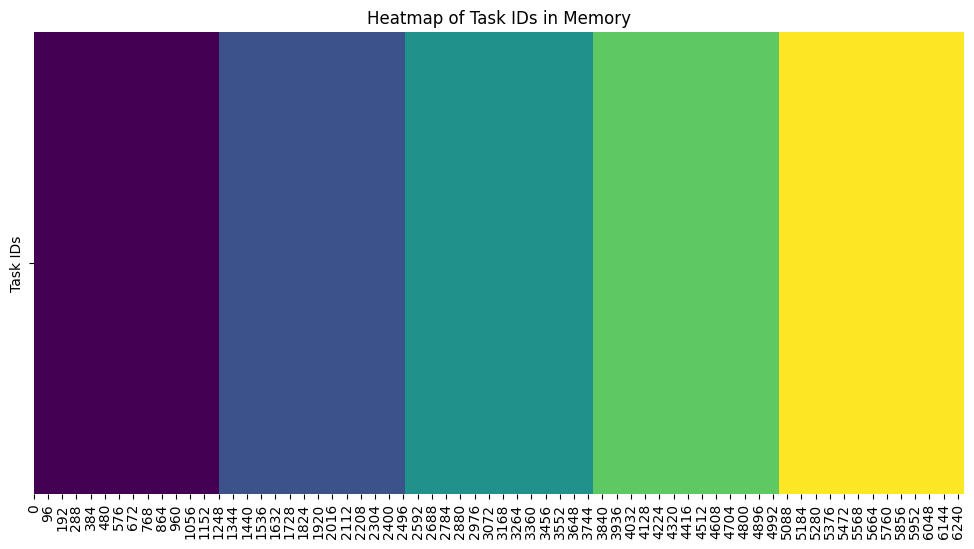

Finished Training
Accuracy on Test Task 1: 44.95%
Accuracy on Test Task 2: 37.80%
Accuracy on Test Task 3: 28.75%
Accuracy on Test Task 4: 59.60%
Accuracy on Test Task 5: 75.95%


[44.95, 37.8, 28.749999999999996, 59.599999999999994, 75.94999999999999]

In [42]:
## Conv3Net on normal data:

# Initialize the nmodel, criterion, optimizer
model = Conv3Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train the model
train(model, criterion, optimizer, train_dataloaders, val_dataloaders, num_epochs=10, replay_capacity=10000)

test_performance(model, test_dataloaders)

## Corruption without LAP

Training on Split 1:


Validation Epoch 10/10: 100%|██████████| 31/31 [00:00<00:00, 193.46it/s, acc=74.9, loss=0.491]


Training on Split 2:


Validation Epoch 10/10: 100%|██████████| 31/31 [00:00<00:00, 187.01it/s, acc=80, loss=0.515]


Training on Split 3:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 180.13it/s, acc=65, loss=0.897]


Training on Split 4:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 185.26it/s, acc=74, loss=0.757]


Training on Split 5:


Validation Epoch 10/10: 100%|██████████| 33/33 [00:00<00:00, 180.93it/s, acc=76.4, loss=0.731]


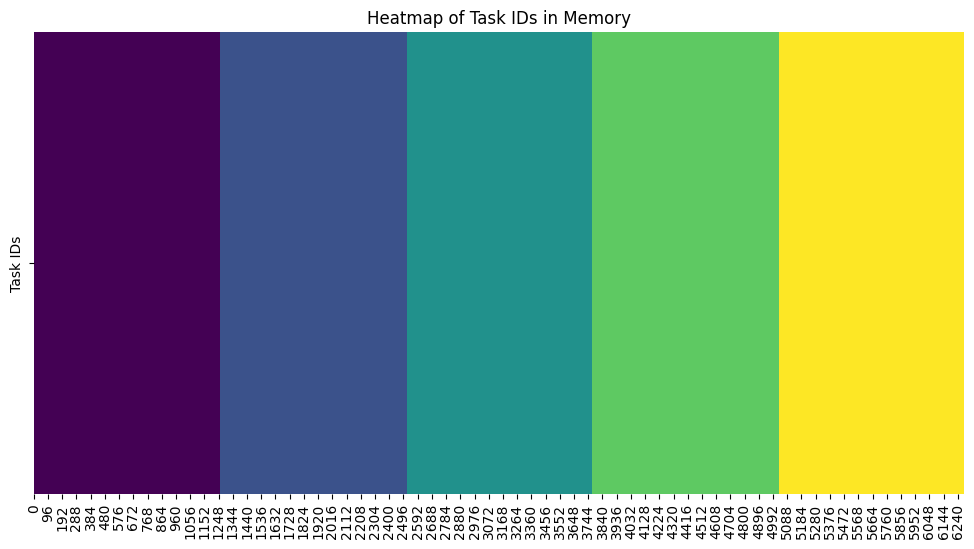

Finished Training
Accuracy on Test Task 1: 70.25%
Accuracy on Test Task 2: 25.60%
Accuracy on Test Task 3: 19.15%
Accuracy on Test Task 4: 20.15%
Accuracy on Test Task 5: 82.75%


[70.25, 25.6, 19.15, 20.150000000000002, 82.75]

In [43]:
## Conv3Net on corrupted data:

# Initialize the nmodel, criterion, optimizer
model = Conv3Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train the model
train(model, criterion, optimizer, train_dl_corr, val_dl_corr, num_epochs=10, replay_capacity=20000)

test_performance(model, test_dl_corr)

## Corruption With LAP

Training on Split 1:


Validation Epoch 10/10: 100%|██████████| 31/31 [00:00<00:00, 169.67it/s, acc=77.1, loss=0.444]


Training on Split 2:


Validation Epoch 10/10: 100%|██████████| 31/31 [00:00<00:00, 163.23it/s, acc=78.6, loss=0.547]


Training on Split 3:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 165.14it/s, acc=63.9, loss=0.995]


Training on Split 4:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 167.92it/s, acc=71.5, loss=0.879]


Training on Split 5:


Validation Epoch 10/10: 100%|██████████| 33/33 [00:00<00:00, 156.04it/s, acc=76, loss=0.752]


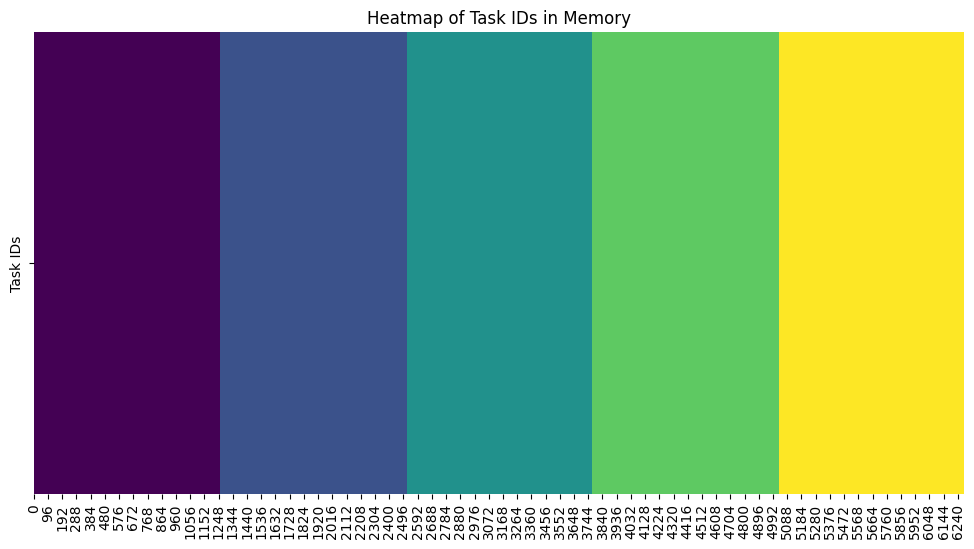

Finished Training
Accuracy on Test Task 1: 64.95%
Accuracy on Test Task 2: 39.10%
Accuracy on Test Task 3: 29.10%
Accuracy on Test Task 4: 25.05%
Accuracy on Test Task 5: 84.25%


[64.95, 39.1, 29.099999999999998, 25.05, 84.25]

In [45]:
## Conv3Net on corrupted data:

# Initialize the nmodel, criterion, optimizer
model = Conv3Net()
criterion = nn.CrossEntropyLoss()
optimizer = LAP(torch.optim.SGD, params = model.parameters(), lr=0.01, depression_function_kwargs = {'hold_off': 100})

# Train the model
train_lap(model, criterion, optimizer, train_dl_corr, val_dl_corr, num_epochs=10, replay_capacity=20000)

test_performance(model, test_dl_corr)

In [ ]:
## Should start tensorboard

%load_ext tensorboard
%tensorboard --logdir logs